<div style="position:relative;">
<img src=images/tensorflow.png style="width: 60px; float: left" />
</div>
<div style="position:relative;">
<img src=images/tensorflow.png style="width: 60px; float: right" />
</div>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Tensorflow


Tensorflow is an open-source symbolic math library. Mostly it is used to implement machine learning algorithms in particular neural networks.

In this exercise you will learn about:
  - the basic buildings blocks of tensorflow, namely: `tf.Tensor`, `tf.Operation`, `tf.Graph`, `tf.Session`
  - the modules to implement neural networks, namely: `tf.layers`, `tf.losses`, `tf.summary`
  - the builtin visualization tool `tensorboard`
  - the high-level estimator API of tensorflow
    
If you get stuck at any point in the tutorial please raise your hand, and one of the tutors will get to you as soon as possible.

<div style="position:relative;">
  <img src="images/tensorflow_programming_environment.png" style="width: 80%; float: left" />
</div>

By convention the tensorflow package is usually imported as **tf**

In [1]:
import tensorflow as tf

/home/thomas/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Low-Level API: Basic Building Blocks

This low level introduction is based on: https://www.tensorflow.org/programmers_guide/low_level_intro

## `tf.Tensor`

A **symbolic representation** of a n-dimensional array with a **dtype**, a **shape** and a **name**.

Tensors do not have **values**, they are just handles to elements in the computation graph.

The **values** of a tensor are represented by `np.ndarray`s during the computation.

### Constant Tensors

Below you see a constant tensor.

During the calculation this tensor behaves like `np.array([1,2,3])`. 

In [2]:
tf.constant([1,2,3])

<tf.Tensor 'Const:0' shape=(3,) dtype=int32>

### Variable Tensors

Below you see a variable tensor, it can be adapted during the calculation. 
The parameters (weights) of a neural network are represented as **variable** tensors in Tensorflow, because they will be updated during the minimization step of the network.

In [3]:
tf.Variable([1,2,3])

<tf.Variable 'Variable:0' shape=(3,) dtype=int32_ref>

### Placeholder Tensors

Below you see a placeholder tensor, it will be replaced with input data during the computation.
The training dataset (features and labels), which is used to train a neural network, are represented by **placeholder** tensors.

Here we define a placeholder for a matrix with an arbitrary number of rows (`None`) and three columns.
The number of rows is arbitrary because we don't know (or rather don't need to know) the number of training samples we will use in the end.

In [4]:
tf.placeholder(dtype=tf.float32, shape=[None, 3])

<tf.Tensor 'Placeholder:0' shape=(?, 3) dtype=float32>

## `tf.Operation`

A `tf.Operation` takes zero or more `tf.Tensor`s and outputs zero or more `tf.Tensor`s.

There are a lot of pre-defined operations:
  - `tf.add`, `tf.multiply`, `tf.matmul`, ...
  - `tf.reduce_sum`, `tf.reduce_mean`, `tf.reduce_max`, ...
  - `tf.tanh`, `tf.nn.relu`, `tf.nn.softmax`, ...
  - `tf.reshape`, ...
  - `tf.nn.conv2d`, `tf.nn.max_pool`, `tf.nn.dropout`, ...

In [5]:
import numpy as np

A very basic example of a `tf.Operation` is a matrix multiplication `tf.matmul`.
Here we define a 90° rotation along the z-axis (symbolised by a constant tensor `R`). We rotate an arbitrary number of 3-vectors (symbolised by a placeholder tensor `x`) using this rotation matrix. The result of this operation are an arbitrary number of rotated 3-vectors (symbolised by another tensor `y`).

In [6]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 3], name='x')
R = tf.constant([[ 0.0, 1.0, 0.0],
                 [-1.0, 0.0, 0.0],
                 [ 0.0, 0.0, 1.0]], name='R')
y = tf.matmul(x, R)
y

<tf.Tensor 'MatMul:0' shape=(?, 3) dtype=float32>

We can do further calculations with `y`. For example we can calculate the norm of the 3-vector and explicitly check if our rotation left the norm invariant by comparing the result to the norm of our original 3-vectors.
The final result will be an arbitrary number of boolean values (symbolised by the tensor `invariant`)

In [7]:
invariant = tf.equal(tf.norm(y, axis=1), tf.norm(x, axis=1))
invariant

<tf.Tensor 'Equal:0' shape=(?,) dtype=bool>

Until know we only defined our calculation in symbolic terms. We did not actually calculate anything yet!
Remember tensorflow is a **symbolic** math library.

## `tf.Graph`

The **symbolic calculation** is represented by a `tf.Graph`.
  - Allows optimized execution on CPU, GPU, or even distributed
  - Graph can be used for automatic differentation

In [8]:
# This is just some nice visualization code and not part of the tutorial.
# You can ignore this cell for the moment

class TensorflowGraphToDot:
    def __init__(self, op, suppressed_nodes = []):
        import collections
        from graphviz import Digraph
        self.dot = Digraph()
        self.dot.graph_attr['size'] ='6,6'
        self.nodes = collections.OrderedDict()
        import tensorflow.contrib.graph_editor as ge
        for node in ge.get_backward_walk_ops(op):
            self.nodes[node.node_def.name] = node.node_def.input
        self.suppressed_nodes = suppressed_nodes
        for node_name in self.nodes:
            self.draw_node(node_name)
            for input_node in self.nodes[node_name]:
                self.draw_edge(input_node, node_name)
    
    def is_suppressed(self, node_name):
        return any([s in node_name for s in self.suppressed_nodes])

    def draw_edge(self, from_node_name, to_node_name):
        if self.is_suppressed(from_node_name):
            if from_node_name in self.nodes:
                for next_node_name in self.nodes[from_node_name]:
                    self.draw_edge(next_node_name, to_node_name)
        else:
            if not self.is_suppressed(to_node_name):
                self.dot.edge(from_node_name, to_node_name)

    def draw_node(self, node_name):
        if not self.is_suppressed(node_name):    
            self.dot.node(node_name, label=node_name)
    
    def _repr_svg_(self):
        return self.dot._repr_svg_()

Our calculation is stored as a `tf.Graph`.
Here we visualize the entire symbolic calculation we defined above.
  - the nodes are `tf.Operation`s
  - the edges in between are `tf.Tensor`s

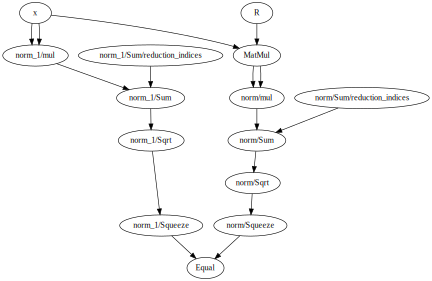

In [9]:
TensorflowGraphToDot(invariant)

### Automatic Differentiation

Tensorflow can automatically differentiate a graph with respect to one of its constituents.
The result will be another graph, which calculates the gradients.

For the training of arbitrary neural networks this is a huge advantage, because we only have to implement the forward pass of the neural network, and the necessary calculations for the backpropagation can be automatically generated by tensorflow!

In this sense: **the back-propagation algorithm is part of the design of tensorflow**

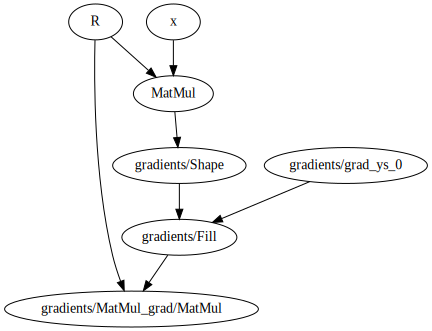

In [10]:
partial_derivative = tf.gradients(y, x)
TensorflowGraphToDot(partial_derivative)

## `tf.Session`

Executes the `tf.Operation`s of a `tf.Graph` on different devices (CPUs, GPUs, Distributed, ...).

**If a tf.Graph is like a .py file, a tf.Session is like the python executable.**

So far we still have not calculate anything! Let's do this now!
You can execute your symbolic calculation on different devices, tensorflow will automatically generate the necessary code for you. So if you want to run your calculation on a GPU there is no need to learn e.g. CUDA (the API used to develop code for Nvidia GPUs), tensorflow will handle everything for you in the background!

The `tf.Session` is responsible for setting up the necessary environment.

In this tutorial we stick to executing our calculations on CPU.

In [11]:
session = tf.InteractiveSession()
session.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

Once we defined our session, we can run our calculations.
Just pass the `tf.Tensor` object you want to calculate to the `run` method of the session.

Here we want to calculate $y = R \cdot x$, which we defined earlier.
However, while `R` was a constant tensor with actual numbers, x was just a placeholder for some arbitrary vectors. So if we want to calculate `y` we have to provide some 3-vectors which will be used during the calculation inplace of `x`.
We provide two 3-vectors, and tensorflow calculates the resulting two rotated 3-vectors.

In the feed_dict you have to provide the necessary data for each placeholder involved in the calculation.

In [12]:
session.run(y, feed_dict={x: [[1,2,3], [4,5,6]]})

array([[-2.,  1.,  3.],
       [-5.,  4.,  6.]], dtype=float32)

Next we execute our calculation, which tests the invariance of the norm of 3-vectors under rotation.
This time we provide 50 random 3-vectors inplace of x.
The result are 50 boolean values (and hopefully all are True)

In [13]:
session.run(invariant, feed_dict={x: np.random.uniform(size=(50, 3))})

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

It is time for an exercise!
You will have some time to do the following exercise (~10 Minutes).
Again, if you get stuck, raise your hand and a tutor will get back to you as soon as possible.

<div class="alert alert-block alert-info">
<h3>Exercise</h3>
Modify the above code to calculate a simple percepetron:

$$ y = \tanh(W \cdot x + b) $$

Execute the calculation with numpy and with tensorflow.

<h3>Question</h3>
Take a look at the partial derivative $\frac{\partial y}{\partial x}$.
Why does tensorflow still calculates the $\tanh$ term and not the derivative?
</div>

# MNIST

The MNIST database (Modified National Institute of Standards and Technology database) is a **dataset**
  - 28x28 images showing handwritten digits
  - 55K training, 5K validation and 10K test samples
  - multi-class classification task

The MNIST dataset is the **hello world** task of (image-based) machine learning.
Throughout this tutorial we will stick to the MNIST dataset to keep things as simple as possible.
But of course you can later apply your new knowledge to something completely different (e.g. astro-particle physics)

Each image is represented by a 784-dimensional vector, and its label is represented by a 10-dimensional one-hot encoded vector. So, for instance the digit 3 would have the label (0,0,1,0,0,0,0,0,0,0)

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


It is always a good idea to first visualize some training samples, to get to know the data.

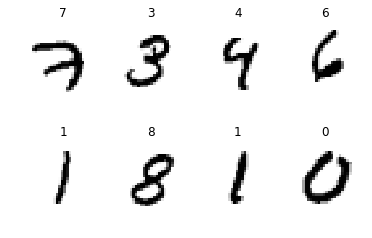

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4)
for i, ax in enumerate(axes.flat):
    ax.set_title(mnist.train.labels[i].argmax())
    ax.imshow(mnist.train.images[i].reshape(28,28), cmap=plt.cm.Greys)
    ax.axis('off')

## Linear Model

In machine learning it is best practise to start with the simplest model to establish the overall procedure.

We implement a linear model $f$ with weights $W$:
$$ f: R^{784} \rightarrow [0, 1]^{10}$$

$$ f(\vec{x}) = \underbrace{\frac{\exp \vec{l}}{\sum_{i=1}^{10} \exp l_i}}_{\mathrm{softmax}(l)} \quad \quad \textrm{where} \quad \vec{l} = W \cdot \vec{x}$$


The linear model maps the 784 dimensional input vector onto 10 outputs.
A linear model is a neural network where the input layer (784 neurons) is directly connected to the output layer (10 neurons).

Each output should be the probability that a certain digit is shown. For instance, the first output is the probability that the image shows a 1, the second output is the probability that the image shows a 2, and so on...
Overall the probabilities should sum up to 1!
A simple way to achieve this, is by applying the softmax activation function to the output neurons (see definition above).

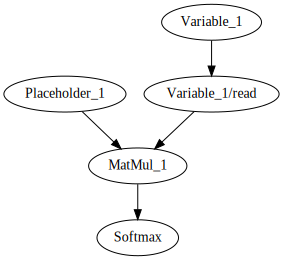

In [16]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
W = tf.Variable(tf.zeros([784, 10]))
logits = tf.matmul(x, W)
probabilities = tf.nn.softmax(logits)
TensorflowGraphToDot(probabilities)

### Loss-function

For **multi-class classification** one usually wants to minimize the **cross-entropy**.

$$ H(y,p) = - \sum_{i=1}^{10} y_i \log p_i $$

Keep in mind that we always operate on a batch of images (for instance $N = 100$ images per minimization-step).
Therefore our loss-function is the average cross-entropy.
$$ \mathcal{L} = \frac{1}{N} \sum_{j=1}^{N} H(y_j,p_j) $$

The cross entropy loss-function is particulary well-suited for multi-class classification problems.

In [17]:
cross_entropy = -tf.reduce_sum(y * tf.log(probabilities + 0.001), axis=[1])
loss_function = tf.reduce_mean(cross_entropy)

### Optimization
We use a simple gradient-descent optimizer.

$$ \Delta W = - \eta \frac{\partial \mathcal{L}}{\partial W} \quad \quad \textrm{where} \quad \eta = 0.5 $$


Tensorflow provides many different optimizers
  - tf.train.AdamOptimizer
  - tf.train.FtrlOptimizer
  
Empirically you can expect that a more advanced optimizer will:
  - converge faster
  - generalize worse (although there is some debate why...)
Surprisingly, `L-BFGS` is not available, but at least I never missed it.

In [18]:
minimize = tf.train.GradientDescentOptimizer(0.5).minimize(loss_function)

### Training

Training in tensorflow means just running the **minimize** operation multiple times, here we run 1000 minimization steps. In each step we process a batch of 100 images, and adjusts the weights to minimize the mean cross-entropy of the batch.

### Initializing the Session

Before the training we have to open a new session and initialize all global variables used by tensorflow internally

In the next line we directly execute the tf.global_variables_initializer operation by calling its `run` method.
This is a short hand for `session.run(tf.global_variables_initializer())`

In [19]:
session = tf.InteractiveSession()
tf.global_variables_initializer().run()

### The main training loop

Efficiently loading, preprocessing, shuffling and iterating through your training dataset is a huge topic. But we don't have the time to go into detail here. Tensorflow does have the capability to asynchroneously load your data from disk or from the network, while your current batch is processed.

Here we just load the training images of the mnist dataset, 100 at a time, and pass it to the `minimize` operation using the `feed_dict`. For each call of `minimize` the optimizer performs one optimization step. In total we perform 1000 optimization steps.
In practise you can use **early stopping** to dynamically decide how many steps you want to do.

In [20]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    session.run(minimize, feed_dict={x: batch_xs, y: batch_ys})

### Direct Evaluation

Finally we evaluate the linear model. We are interested in the **accuracy** of our model.

We used the `tf.nn.softmax` activation function. So our linear model will output a vector of numbers between 0 and 1. Each number can be interpreted as the probability of the image showing a certain digit.
So to evaluate our model we have to check how often the position of the highest probability coincidents with the correct label (here the label is one-hot encoded, so we have to take `tf.argmax` here as well).

In [21]:
correct_prediction = tf.equal(tf.argmax(probabilities, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Train", session.run(accuracy, feed_dict={x: mnist.train.images, y: mnist.train.labels}))
print("Test ", session.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Train 0.9164364
Test  0.9173


<div class="alert alert-block alert-info">
<h3>Exercise</h3>
Add a bias $\vec{b}$ to the linear model

$$ f(\vec{x}) = \underbrace{\frac{\exp \vec{l}}{\sum_{i=1}^{10} \exp l_i}}_{\mathrm{softmax}(l)} \quad \quad \textrm{where} \quad \vec{l} = W \cdot \vec{x} + \vec{b}$$

<h3>Question</h3>
What is the purpose of the bias?
</div>

# Neural Network in Tensorflow

  - Automatic Differentiationen $\rightarrow$ you only implement the forward pass
  - Graph is automatically compiled for CPU, GPU, TPU, ... $\rightarrow$ you don't have to write C++, CUDA, ...
  - Predefined functions for neural network building blocks $\rightarrow$ you don't have to implement convolution yourself

**Let us take a look at those predefined functions**

## `tf.layers`

The `tf.layers` package contains pre-defined layers commonly used in neural networks:
  - convolution layers: `tf.layers.conv2d`
  - pooling layers: `tf.layers.max_pooling2d`
  - dense (or fully-connected) layers: `tf.layers.dense`

https://www.tensorflow.org/api_docs/python/tf/layers

Using those layers we can easily build a more complex neural network without having to define the weight variables ourselves (like we did in the low-level exercise).

Here we write our first "real" neural network:
    1. We reshape the 1-dimensional 784 array to a 28x28x1 tensor (the 2d image with 1 channel)
    2. We apply a 2d-convolution followed by a ReLU activation function onto the image and get out a 28x28x32 tensor (32 2d feature maps)
    3. We apply max-pooling to reduce the resolution of the feature maps (7x7x32)
    4. We flatten the 2d-feature maps and obtain an 1568 dimensional intermediate representation
    5. We apply a fully-connected layer (also called dense layer) with 10 outputs and a linear activation function

The resulting graph is already quite complicated.
As you can see you could easily add additional convolution layers.

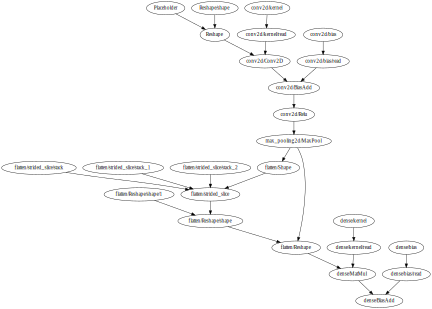

In [37]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784])
image = tf.reshape(x, [-1, 28, 28, 1])
conv = tf.layers.conv2d(image, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
pool = tf.layers.max_pooling2d(conv, pool_size=[4, 4], strides=4)
flat = tf.layers.flatten(pool)
logits = tf.layers.dense(flat, units=10)
TensorflowGraphToDot(logits)

### Initalization and Regularization

The layers provided by `tf.layers` have a common interface to define initalization and regularization.
Most layers have at least the following parameters:
 - `activation`, the activation function used by this layer  e.g. `tf.nn.relu`
 - `kernel_initializer`, the initalisation function used to intialize the weights of the layer
 - `kernel_regularizer`, the regularizer used to regularize the weights of the layer e.g. $L_2$ or $L_1$
 - `kernel_constraint`, a projection function to enforce certaint constraints on the weights
 
We won't go into further detail here. But we will use initialization and regularization in the high-level exercise using `tf.keras` later.

## `tf.losses`

The `tf.losses` package contains pre-defined loss-functions commonly used in neural networks.
In contrast to the low-level API, the loss is automatically averaged over the current batch.

https://www.tensorflow.org/api_docs/python/tf/losses

Above we did define the cross-entropy loss ourselves. You should **never** do this. Implementing cross-entropy has many pitfalls and can easily get numerically instable. In particular in combination with the softmax operation (summation of exponentation followed by logarithm again!)

Therefore it is best to apply the softmax and cross-entropy together, in one optimized function called `tf.losses.softmax_cross_entropy`.

You can ignore the WARNING below, internally `tf.losses.softmax_cross_entropy` uses a deprecated function, this is something the tensorflow people have to fix :-)

In [38]:
y = tf.placeholder(tf.float32, [None, 10])
loss_function = tf.losses.softmax_cross_entropy(y, logits=logits)
minimize = tf.train.GradientDescentOptimizer(0.5).minimize(loss_function)

## `tf.summary`

During the training you can sample interesting quantities.
Here we define two summary objects:
  - a scalar summary (`tf.summary.scalar`), which records the accuracy during the training
  - a histogram summary (`tf.summary.histogram`), which records the distribution of the maximum probability of each sample (a measure on "how confident" our network is in its decision)
  

In practise you will spent most of your time in debugging your network to obtain a stable training procedure with a good performance. Therefore it is important to have efficient ways to monitor and visualize your training procedure.

Do not try to monitor you training with print statements, this approach does not scale. Always invest time to learn to use the right tool for a job, in this case `tf.summary` and `tensorboard`

In [39]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('summary/accuracy', accuracy)
tf.summary.histogram('summary/max_probability', tf.reduce_max(tf.nn.softmax(logits), axis=1))
summary = tf.summary.merge_all()

train_writer = tf.summary.FileWriter('train_log')
train_writer.add_graph(tf.get_default_graph())
test_writer = tf.summary.FileWriter('test_log')

In addition to our previously established training procedure (calling minimize many times),
we monitor our training by executing the summary operation after 10 minimization steps.
We monitor the summary on the training sample, and on the test sample (so we can check for over-fitting!).
Also we restrict the number of samples to 1000 for the summary, to speed up the computations.

In [40]:
session = tf.InteractiveSession()
tf.global_variables_initializer().run()
for i in range(100):
    batch_xs, batch_ys = mnist.train.next_batch(128)
    session.run(minimize, feed_dict={x: batch_xs, y: batch_ys})

    if i % 10 == 0:
        print(i)
        train_summary = session.run(summary, feed_dict={x: mnist.train.images[:1000], y: mnist.train.labels[:1000]})
        train_writer.add_summary(train_summary, i)
        test_summary = session.run(summary, feed_dict={x: mnist.test.images[:1000], y: mnist.test.labels[:1000]})
        test_writer.add_summary(test_summary, i)    

0
10
20
30
40
50
60
70
80
90


Let's check if we are actually improved on our previously established baseline.
You should get out an accuracy above 94% now.

In [35]:
print("Train", session.run(accuracy, feed_dict={x: mnist.train.images[:1000], y: mnist.train.labels[:1000]}))
print("Test ", session.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Train 0.934
Test  0.948


## `Tensorboard`

  - browser-based application
  - visualizes the `tf.Summary` objects sampled during the training
  - inspect, monitor and visualize the learning process of a neural network


<div class="alert alert-block alert-info">
<h3>Exercise</h3>
You can now start tensorboard and inspect your training by executing the following command in `bash` <br>
<pre> tensorboard --logdir="." </pre>

Afterwards open your browser at:
http://localhost:6006
</div>

<div class="alert alert-block alert-info">
<h3>Exercise</h3>
In addition to the current summaries: visualize the loss function (scalar) and the distribution of the weights (histogram) in tensorboard.
</div>

# High Level Interface - Estimators

Tensorflow is not as easy to use as:
  - sklearn
  - keras
  - ...

The High-Level Tensorflow API was recently introduced to simplify using tensorflow.

It provides an sklearn-like estimator interface, which encapsulates the following actions:
  - training
  - evaluation
  - prediction
  - export for serving
    
It tries to hide tensoflow-details:
  - no need to open a session
  - no explicit training loop

## Estimator-Interface vs. Keras

Clearly the estimator interface is aimed to be an alternative to Keras, which is the high-level interface most people use.

**Personal Opinion**: The estimator interface is still very confusing, hence we will look into **Keras** for the second part of this workshop!

In the following I implemented our above code using the estimator-interface of tensorflow.
Hence, you can form your own opinion.

The rest of this notebook is **NOT** part of the workshop and is **not part of the exam**.

The basic idea is to have one model-function defines the prediction, training and validation operations.

In [27]:
def model(features, labels, mode):
    # Our model (same architecture as above)
    image = tf.reshape(features["x"], [-1, 28, 28, 1])
    conv = tf.layers.conv2d(image, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2)
    flat = tf.layers.flatten(pool)
    logits = tf.layers.dense(flat, units=10)
    
    # The predicted class is the position of the maximum output.
    # The probabilities are calculated using softmax
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # The loss is still based on cross-entropy as above
    loss = tf.losses.softmax_cross_entropy(labels, logits=logits)
    # And we still use the usual Stochastic Gradient Descent optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        minimize = tf.train.GradientDescentOptimizer(0.5).minimize(loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=minimize)

    # Our evaluation metric is the accuracy
    eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(labels=tf.argmax(labels, axis=1), predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

Now we can define our estimator. 
The `session_config` of the `tf.estimator.RunConfig` replaces the direct usage of `tf.Session`

In [28]:
classifier = tf.estimator.Estimator(
    model_fn=model,
    model_dir='/tmp/mymodel',
    config=tf.estimator.RunConfig(session_config=tf.ConfigProto()),
);

INFO:tensorflow:Using config: {'_master': '', '_task_type': 'worker', '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6fd08d9c88>, '_is_chief': True, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/mymodel', '_service': None, '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_task_id': 0, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_session_config': }


We train our classifier using the `train` method.

Instead of providing the training data via the `feed_dict` of the session, wen have to wrap it in an `numpy_input_fn`, which is responsible for creating our batches and shuffelong the data.

In [29]:
numpy_input_fn = tf.estimator.inputs.numpy_input_fn
classifier.train(input_fn=numpy_input_fn({"x": mnist.train.images},
                                         mnist.train.labels,
                                         batch_size=128, num_epochs=None, shuffle=True,),
                 steps=100)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mymodel/model.ckpt.
INFO:tensorflow:loss = 2.2913356, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /tmp/mymodel/model.ckpt.
INFO:tensorflow:Loss for final step: 0.19980332.


After the training we can evaluate the performance of our classifier on the test dataset using the `evaluate` method.

In [30]:
results = classifier.evaluate(input_fn=numpy_input_fn({"x": mnist.test.images}, mnist.test.labels, shuffle=False))
print('-' * 30)
print('Results out-of-sample')
for key in sorted(results):
    print('%s: %s' % (key, results[key]))

INFO:tensorflow:Starting evaluation at 2018-03-29-13:55:19
INFO:tensorflow:Restoring parameters from /tmp/mymodel/model.ckpt-100
INFO:tensorflow:Finished evaluation at 2018-03-29-13:55:25
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.9403, global_step = 100, loss = 0.20117736
------------------------------
Results out-of-sample
accuracy: 0.9403
global_step: 100
loss: 0.20117736
